# Hyperparameter tuning

This notebook will walk through how to perform hyperparameter tuning and distributed tuning for ML models in `TF-MELT`

## NREL Kestrel notes

Follow these steps:

1) Log into kestrel: username@kestrel.hpc.nrel.gov
2) Ensure the following are installed in your conda environment:
    - `conda install ipykernel`
    - `python -m ipykernel install --user --name tfmelt --display-name tfmelt` (this make sure that you can access the conda env in the jupyter notebook)
3) Request interactive node:
    - `salloc -A aiuserapps --partition=gpu-h100 --time 24:00:00 --gpus=1`
    - `module load conda`
    - `conda activate tfmelt`
    - `jupyter-notebook --no-browser --ip=$(hostname -s)`
4) On personal computer ssh into the remote session with:
    - `ssh -N -L 8888:<node_name>:8888 <user_name>@kestrel.hpc.nrel.gov`
5) Copy the URL from the interactive node and paste into a browser window. It will look something like:
    - `http://127.0.0.1:8888/?token=<alphabet_soup>`
    - 
    - 

## Building the Tensorflow container
1) Install Docker on your local machine
2) Edit `Dockerfile` to include all the dependencies that you require
3) Run:
    `docker build -t tensorflow-tf-melt-kestrel . --platform=linux/amd64`
4) Export to a tar
    `docker image save tensorflow-tf-melt-kestrel -o tensorflow-tf-melt-kestrel.tar`
5) If the tar is large, it can be compressed:
    `tar czf tensorflow-tf-melt-kestrel.tar.gz tensorflow-tf-melt-kestrel.tar`
6) upload to Kestel:
    `rsync -aP --no-g tensorflow-tf-melt-kestrel.tar.gz nwimer@kestrel.hpc.nrel.gov:/scratch/nwimer/.`
7) Convert to an apptainer container:
    - First request an interactive node, then:

```bash
cd /scratch/$USER
module load apptainer/1.1.9
tar xzf tensorflow-tf-melt-kestrel.tar.gz tensorflow-tf-melt-kestrel.tar
# apptainer build tensorflow-tf-melt-kestrel.sif docker-archive://tensorflow-tf-melt-kestrel.tar
apptainer build --sandbox tensorflow-tf-melt-kestrel/ docker-archive://tensorflow-tf-melt-kestrel.tar


# First check local

In [5]:
import os
from importlib_metadata import version

print(f"TF-MELT version: {version('tfmelt')}")

# Get the number of cpus available
num_cpus = os.cpu_count()
print(f"Number of CPUs: {num_cpus}")

TF-MELT version: 0.4.5
Number of CPUs: 14


In [2]:
import sklearn.datasets as sdt
import matplotlib.pyplot as plt

# Create surogate data
n_samples = 1000
n_features = 10
n_info = 5
n_targets = 3
noise = 10

x, y = sdt.make_regression(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=n_info, 
    n_targets=n_targets, 
    noise=noise, 
    random_state=42,
)
print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Shape of x: (1000, 10), Shape of y: (1000, 3)


In [3]:
from tfmelt.utils.preprocessing import get_normalizers
from sklearn.model_selection import train_test_split

# Get the normalizers using the tfmelt library
x_normalizer, y_normalizer = get_normalizers(norm_type="standard", n_normalizers=2)

# Fit the normalizers
x_normalizer.fit(x)
y_normalizer.fit(y)

# Normalize the data
x_norm = x_normalizer.transform(x)
y_norm = y_normalizer.transform(y)

# Create the train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)

In [60]:
# Do the tuning with ray
import ray
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import HyperBandScheduler, ASHAScheduler, PopulationBasedTraining



# initialize ray
ray.shutdown()
ray.init(num_cpus=num_cpus)

# Put the large objects into the Ray object store
x_train_id = ray.put(x_train)
y_train_id = ray.put(y_train)
x_val_id = ray.put(x_val)
y_val_id = ray.put(y_val)

2024-09-11 13:23:26,113	INFO worker.py:1774 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


In [77]:
from tfmelt.models import ArtificialNeuralNetwork
from tensorflow.keras.optimizers import Adam
from tfmelt.utils.evaluation import make_predictions, ensemble_predictions
from tfmelt.utils.statistics import compute_cwc

def model_builder(config):
    width = config["width"]
    depth = config["depth"]
    act_fun = config["act_fun"]
    dropout = config["dropout"]
    input_dropout = config["input_dropout"]
    batch_norm = config["batch_norm"]
    l1_reg = 0.0
    l2_reg = config["l2_reg"]
    
    learning_rate = config["learning_rate"]
    loss = "mse"

    model = ArtificialNeuralNetwork(
        num_outputs=y_train.shape[1],
        width=width,
        depth=depth,
        act_fun=act_fun,
        dropout=dropout,
        input_dropout=input_dropout,
        batch_norm=batch_norm,
        l1_reg=l1_reg,
        l2_reg=l2_reg,
    )

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss,
    )
    return model

def tune_model(config):
    x_train = ray.get(x_train_id)
    y_train = ray.get(y_train_id)
    x_val = ray.get(x_val_id)
    y_val = ray.get(y_val_id)
    
    model = model_builder(config)
    history = model.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        epochs=200,
        batch_size=512,
        shuffle=True,
        verbose=0,
    )
    val_loss = min(history.history['val_loss'])

    # Evaluate ensemble dropout uncertainty quantification
    pred_train_mean, pred_train_std = ensemble_predictions(model, x_val, n_iter=100, training=True)

    val_cwc = compute_cwc(y_val, pred_train_mean, pred_train_std)

    return {"val_loss": val_loss, "val_cwc": val_cwc}

In [112]:
# Define the hyperparameter search space
import numpy as np
dropout_values = np.round(np.arange(0, 0.55, 0.01), 2).tolist()

config = {
    "width": tune.randint(4, 128),
    "depth": tune.randint(1, 8),
    "act_fun": tune.choice(["relu", "leaky_relu", "tanh"]),
    "batch_norm": tune.choice([True, False]),
    "l2_reg": tune.choice([0.0, 1e-1, 1e-2, 1e-3]),
    "learning_rate": tune.choice([1e-3, 3e-4, 1e-4]),
    "dropout": tune.choice(dropout_values),
    "input_dropout": tune.choice(dropout_values),
}

# hyperband = HyperBandScheduler(
#     metric="val_loss",
#     mode="min",
#     max_t=200,  # Maximum number of epochs
#     reduction_factor=3,
# )


asha = ASHAScheduler(
    # metric="val_loss",
    metric="val_cwc",
    mode="min",
    max_t=200,  # Maximum number of epochs
    grace_period=1, # set to 5 for more aggressive pruning
    reduction_factor=2,
)


# pbt = PopulationBasedTraining(
#     # metric="val_loss",
#     metric="val_cwc",
#     mode="min",
#     perturbation_interval=5,  # Number of iterations before exploring new hyperparameters
#     hyperparam_mutations={
#         "learning_rate": [1e-3, 3e-4, 1e-4],
#         "width": tune.randint(4, 32),
#         "depth": tune.randint(1, 4),
#     },
# )


In [113]:
# # Run the hyperparameter search
# band_analysis = tune.run(
#     tune.with_parameters(tune_model),
#     config=config,
#     num_samples=70,  # Number of hyperparameter configurations to try
#     scheduler=hyperband,
#     verbose=1,
# )

asha_analysis = tune.run(
    tune.with_parameters(tune_model),
    config=config,
    num_samples=1000,  # Number of hyperparameter configurations to try
    scheduler=asha,
    verbose=1,
)

# pbt_analysis = tune.run(
#     tune.with_parameters(tune_model),
#     config=config,
#     num_samples=70,  # Number of hyperparameter configurations to try
#     scheduler=pbt,
#     verbose=1,
# )

# Hyperband Results
# with 70 samples and 7 CPUs, it takes about 1 minute and 2 seconds
# with 70 samples and 14 CPUs, it takes about 51 seconds
# with 70 samples and 1 CPU, it takes about 6 minutes and 2 seconds

# ASHA Results
# with 70 samples and 1 CPU, it takes about 6 minutes and 10 seconds
# with 70 samples and 7 CPUs, it takes about 1 minutes and 3 seconds
# with 70 samples and 14 CPUs, it takes about 50 seconds

# PBT Results
# with 70 samples and 1 CPU, it takes about 6 minutes and 2 seconds
# with 70 samples and 7 CPUs, it takes about 1 minute and 2 seconds
# with 70 samples and 14 CPUs, it takes about 56 seconds

2024-09-11 14:53:33,755	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/nwimer/ray_results/tune_model_2024-09-11_14-39-16' in 0.2261s.
2024-09-11 14:53:33,851	INFO tune.py:1041 -- Total run time: 857.31 seconds (856.98 seconds for the tuning loop).


In [114]:
# best_band = band_analysis.get_best_config(metric="val_loss", mode="min")
# print("Best hyperparameters found were: ", best_band)

# band_model = model_builder(best_band)

best_asha = asha_analysis.get_best_config(metric="val_loss", mode="min")
print("Best hyperparameters found were: ", best_asha)

asha_model = model_builder(best_asha)

# best_pbt = pbt_analysis.get_best_config(metric="val_loss", mode="min")
# print("Best hyperparameters found were: ", best_pbt)

# pbt_model = model_builder(best_pbt)


Best hyperparameters found were:  {'width': 87, 'depth': 1, 'act_fun': 'tanh', 'batch_norm': False, 'l2_reg': 0.0, 'learning_rate': 0.0003, 'dropout': 0.18, 'input_dropout': 0.04}


In [115]:
# Train the best model
# band_history = band_model.fit(
#     x_train,
#     y_train,
#     validation_data=(x_val, y_val),
#     epochs=200,
#     batch_size=32,
#     shuffle=True,
#     verbose=1,
# )

asha_history = asha_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=32,
    shuffle=True,
    verbose=1,
)

# pbt_history = pbt_model.fit(
#     x_train,
#     y_train,
#     validation_data=(x_val, y_val),
#     epochs=200,
#     batch_size=32,
#     shuffle=True,
#     verbose=1,
# )

Epoch 1/200
25/25 [==============================] - 0s 2ms/step - loss: 1.0845 - val_loss: 1.2247
Epoch 2/200
25/25 [==============================] - 0s 933us/step - loss: 0.8883 - val_loss: 0.9670
Epoch 3/200
25/25 [==============================] - 0s 940us/step - loss: 0.6989 - val_loss: 0.7646
Epoch 4/200
25/25 [==============================] - 0s 844us/step - loss: 0.5798 - val_loss: 0.6010
Epoch 5/200
25/25 [==============================] - 0s 714us/step - loss: 0.4694 - val_loss: 0.4704
Epoch 6/200
25/25 [==============================] - 0s 753us/step - loss: 0.3820 - val_loss: 0.3625
Epoch 7/200
25/25 [==============================] - 0s 844us/step - loss: 0.3171 - val_loss: 0.2752
Epoch 8/200
25/25 [==============================] - 0s 772us/step - loss: 0.2630 - val_loss: 0.2082
Epoch 9/200
25/25 [==============================] - 0s 928us/step - loss: 0.2062 - val_loss: 0.1576
Epoch 10/200
25/25 [==============================] - 0s 897us/step - loss: 0.1903 - val_loss

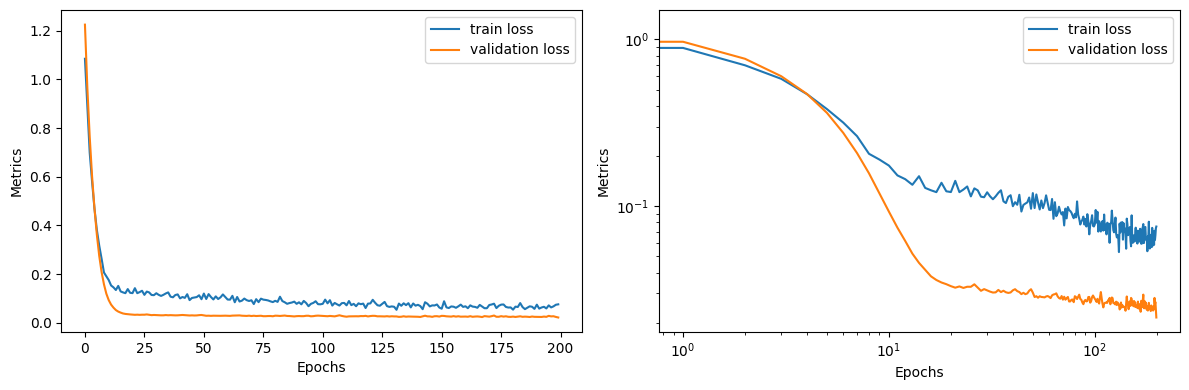

In [116]:
from tfmelt.utils.visualization import plot_history

# plot_history(band_history, plot_log=True)
plot_history(asha_history, plot_log=True)
# plot_history(pbt_history, plot_log=True)

In [117]:
from tfmelt.utils.evaluation import make_predictions

# # Evaluate the model performance on train, validation, and test data
# pred_train_band = make_predictions(band_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
# pred_val_band = make_predictions(band_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
# pred_test_band = make_predictions(band_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

pred_train_asha = make_predictions(asha_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val_asha = make_predictions(asha_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test_asha = make_predictions(asha_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

# pred_train_pbt = make_predictions(pbt_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
# pred_val_pbt = make_predictions(pbt_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
# pred_test_pbt = make_predictions(pbt_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

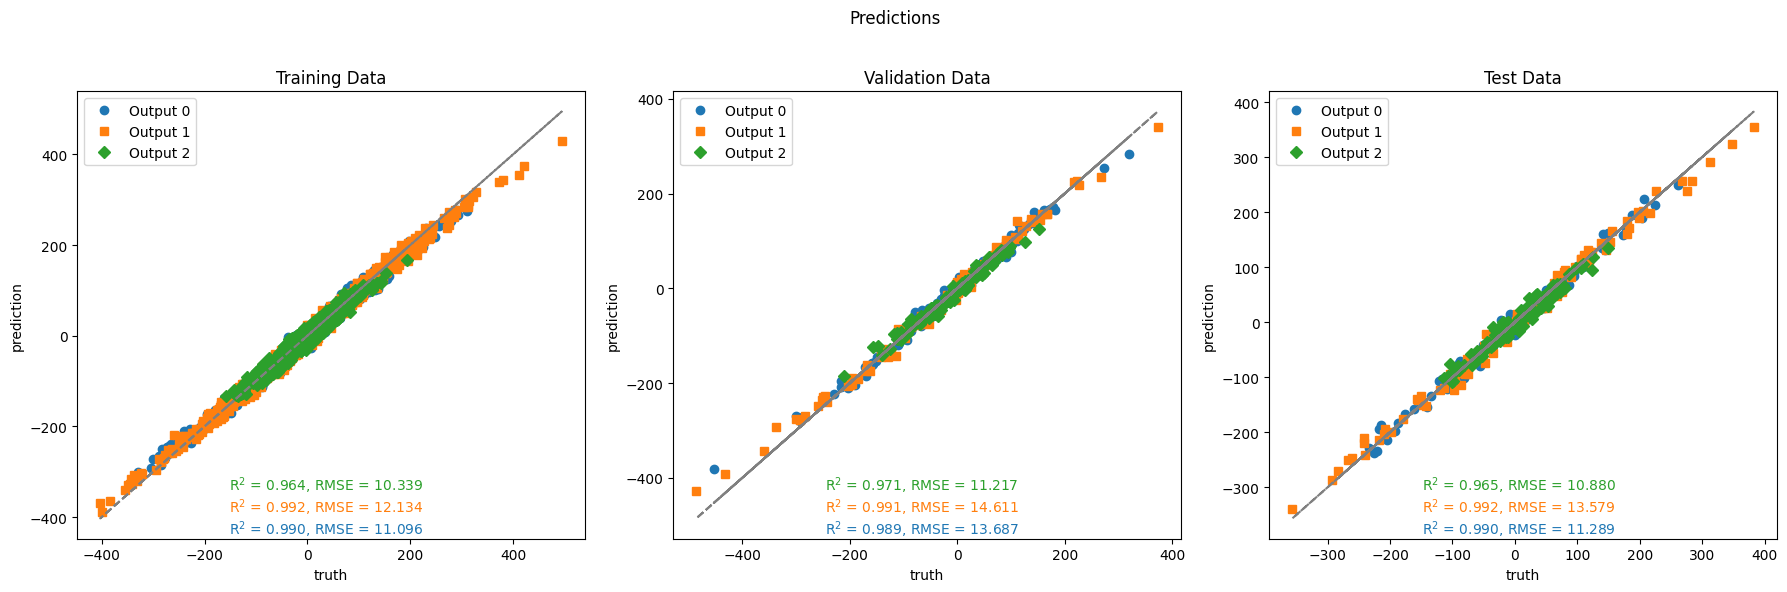

In [118]:
from tfmelt.utils.visualization import plot_predictions

# Plot the predictions
# plot_predictions(pred_train_band, y_train_real, pred_val_band, y_val_real, pred_test_band, y_test_real)
plot_predictions(pred_train_asha, y_train_real, pred_val_asha, y_val_real, pred_test_asha, y_test_real)
# plot_predictions(pred_train_pbt, y_train_real, pred_val_pbt, y_val_real, pred_test_pbt, y_test_real)

In [119]:
from tfmelt.utils.evaluation import ensemble_predictions

pred_train_mean, pred_train_std = ensemble_predictions(asha_model, x_train, y_normalizer=y_normalizer, unnormalize=True, n_iter=100, training=True)
pred_val_mean, pred_val_std = ensemble_predictions(asha_model, x_val, n_iter=100, y_normalizer=y_normalizer, unnormalize=True, training=True)
pred_test_mean, pred_test_std = ensemble_predictions(asha_model, x_test, n_iter=100, y_normalizer=y_normalizer, unnormalize=True, training=True)

# Evaluate ensemble dropout uncertainty quantification
# pred_train_mean, pred_train_std = ensemble_predictions(pbt_model, x_train, y_normalizer=y_normalizer, unnormalize=True, n_iter=100, training=True)
# pred_val_mean, pred_val_std = ensemble_predictions(pbt_model, x_val, n_iter=100, y_normalizer=y_normalizer, unnormalize=True, training=True)
# pred_test_mean, pred_test_std = ensemble_predictions(pbt_model, x_test, n_iter=100, y_normalizer=y_normalizer, unnormalize=True, training=True)



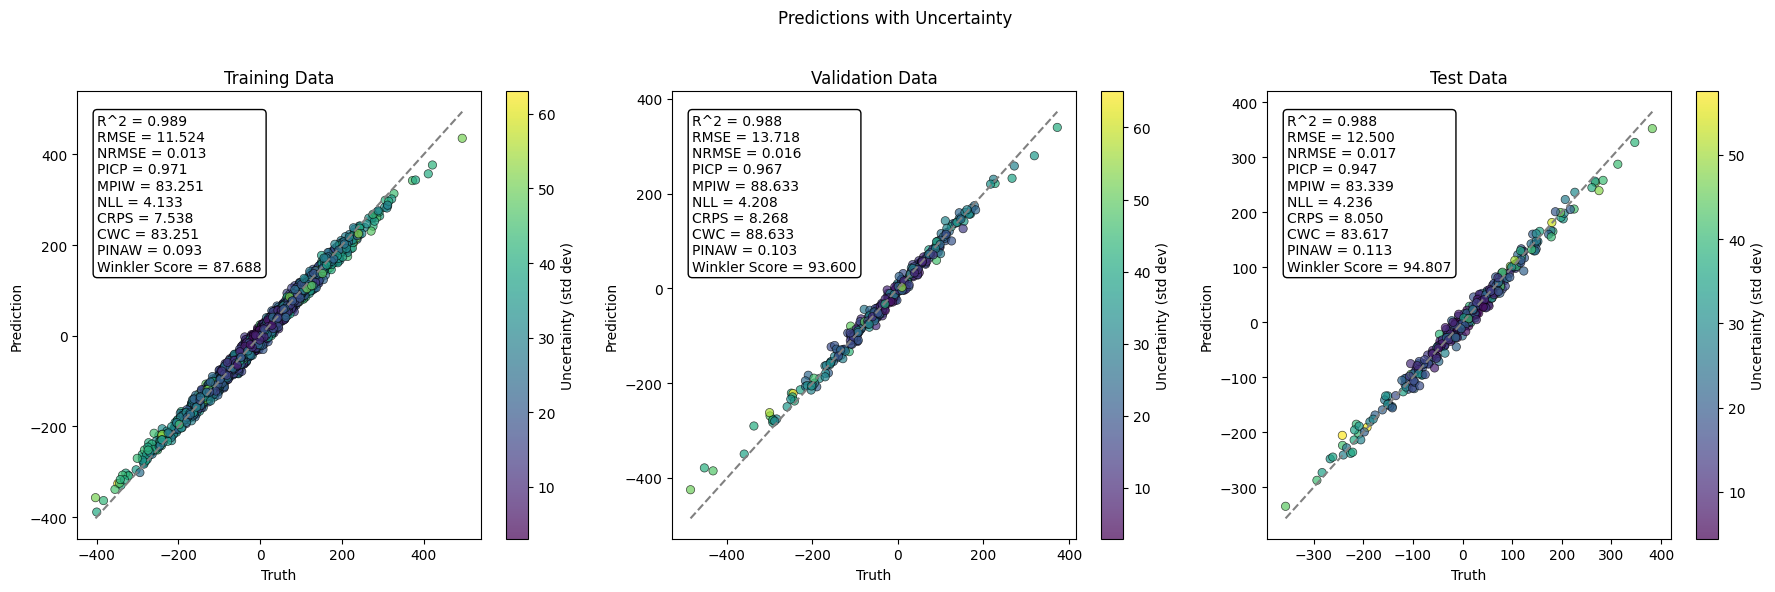

In [120]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

plot_predictions_with_uncertainty(
    pred_train_mean, pred_train_std, y_train_real,
    pred_val_mean, pred_val_std, y_val_real,
    pred_test_mean, pred_test_std, y_test_real,
)